# <h1> ⚙️ DiffAE Manipulation demo for Colab (simplified version) </h1>
[![Full paper](https://img.shields.io/badge/Full_paper-arXiv-b31b1b.svg)](https://arxiv.org/abs/2111.15640)
[![Web](https://img.shields.io/website-up-down-green-red/http/monip.org.svg)](https://diff-ae.github.io/)
[![Github](https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/phizaz/diffae)



<small> this simplified notebook is particular created to demonstrate the manipulation process with DiffAE. <br>
Note: DiffAE does not aim to be an image editing technique. However, with the capability to learn meaningful and rich representation with DiffAE, we show that DiffAE's representation can be meaningfully manipulated without using any fancy trick.

For more detailed and more technical oriented version, please check out our github repository </small>



In [ ]:
#@markdown <h3> 📥 prepare and setup environment</h3>
!pip install --upgrade pip
!pip install torch torchvision torchaudio  pytorch-lightning  torchtext -f https://download.pytorch.org/whl/torch_stable.html
!pip install scipy
!pip install numpy
!pip install tqdm
!pip install pytorch-fid
!pip install pandas
!pip install lpips
!pip install lmdb
!pip install ftfy
!pip install regex
!pip install dlib requests


!git clone https://github.com/phizaz/diffae
!git pull https://github.com/phizaz/diffae



%cd 'diffae'


Looking in links: https://download.pytorch.org/whl/torch_stable.html
Cloning into 'diffae'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 490 (delta 88), reused 81 (delta 78), pack-reused 374
Receiving objects: 100% (490/490), 11.23 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (279/279), done.
From https://github.com/phizaz/diffae
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content/diffae/diffae/diffae


In [ ]:
#@markdown <h3> 🔧 Import libraries and tools </h3>

import os
import os.path as osp
import matplotlib.pyplot as plt

from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

def show_images(images, cols = 1, titles = None, apply_convert=False):
    if apply_convert: images = [convert(img) for img in images]
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images*2)
    plt.show()

def convert2rgb(img,adjust_scale=True):
    convert_img = torch.tensor(img)
    if adjust_scale: convert_img = (convert_img+1)/2
    return (convert_img).permute(1, 2, 0).cpu()

<h3> Model configuration </h3>

In [ ]:
#@markdown <h3> ⚙️ Model Configuration</h3>
#@markdown <small> we have provided 128 and 256 pretrained models; you may train our model with your own preference (checkout our github repository) .</small> <br>
#@markdown <small> T_step:  is the number of step for generation in DiffAE. </small> <br>

device = 'cuda:0'
model_resolution = 256 #@param [128, 256]
T_inv = 200 #@param [50,100,125,200,250,500]
T_step = 100 #@param [50,100,125,200,250,500]

model_config = ffhq256_autoenc() if model_resolution == 256 else  ffhq128_autoenc_130M()

print(model_config.name)


# download model weight & its inferenced latents



ffhq256_autoenc


In [ ]:
#@markdown <h3> 📥  Download pretrained weights </h3>



download_paths = {
    256: {
        'diffae_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/ER56kn-uzlNAi39E1c784qQBkj5RI7-OAZC9QghQsIDQiQ?download=1' ,
        'diffae_latent':  'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/EcZqHAWy2v9GuaXuESDg1tUB4li-hf0aC-2SjeLxB3ASdQ?download=1' ,
        'cls_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/ESzwEubKDNBEmYcbEr9O2jABtNqk_p7f2xYQ_t3PurXnHg?download=1'
    },
    128: {
        'diffae_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/Eb36o-4NlSFGmpj3Vut2p-gBswf8PsUmeiqIEbA8XmAqWA?download=1',
        'diffae_latent': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/EQ9jjIjJRcJCs6h3d_LnJYoBvKk7zEMlHZn5btEKBEYoXg?download=1',
        'cls_weight': 'https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/Eb36o-4NlSFGmpj3Vut2p-gBswf8PsUmeiqIEbA8XmAqWA?download=1'
    }
}

weight_dir_path = f'checkpoints/{model_config.name}'
if not osp.exists(weight_dir_path): os.makedirs(weight_dir_path)
model_download_path = download_paths[model_resolution]['diffae_weight']
latents_download_path = download_paths[model_resolution]['diffae_latent']
!wget -O '{weight_dir_path}/last.ckpt' '{model_download_path}'
!wget -O '{weight_dir_path}/latent.pkl' '{latents_download_path}'



classifer_config = ffhq256_autoenc_cls() if model_resolution == 256 else ffhq128_autoenc_130M()
weight_dir_path = f'checkpoints/{classifer_config.name}'
if not osp.exists(weight_dir_path): os.makedirs(weight_dir_path)
cls_download_path = download_paths[model_resolution]['cls_weight']
!wget -O '{weight_dir_path}/last.ckpt' '{cls_download_path}'

--2024-06-27 13:34:33--  https://vistec-my.sharepoint.com/:u:/g/personal/nattanatc_pro_vistec_ac_th/ER56kn-uzlNAi39E1c784qQBkj5RI7-OAZC9QghQsIDQiQ?download=1
Resolving vistec-my.sharepoint.com (vistec-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to vistec-my.sharepoint.com (vistec-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/nattanatc_pro_vistec_ac_th/Documents/diffae-public/checkpoints/ffhq256_autoenc/last.ckpt?ga=1 [following]
--2024-06-27 13:34:33--  https://vistec-my.sharepoint.com/personal/nattanatc_pro_vistec_ac_th/Documents/diffae-public/checkpoints/ffhq256_autoenc/last.ckpt?ga=1
Reusing existing connection to vistec-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2722085968 (2.5G) [application/octet-stream]
Saving to: ‘checkpoints/ffhq256_autoenc/last.ckpt’

checkpoints/ffhq256 100%[===================>]   2.53G  35.9MB/s    in 51s  

In [ ]:
#@markdown <h3> ⚡ Model Initialization </h3>

model = LitModel(model_config)
state = torch.load(f'checkpoints/{model_config.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

INFO:lightning_fabric.utilities.seed:Seed set to 0


Model params: 160.69 M


<h3> Classifier initialization </h3>
We'll use a trained classifer weight to provide a class direction in our image manipulation process

In [ ]:
#@markdown <h3>  🐶 😸  Classifier Initialization  </h3>

classifier_config = ffhq256_autoenc_cls() if model_resolution == 256 else ffhq128_autoenc_cls()
classifier_config.pretrain = None # a bit faster
classifier = ClsModel(classifier_config)
state = torch.load(f'checkpoints/{classifer_config.name}/last.ckpt', map_location='cpu')
print('latent step:', state['global_step'])
classifier.load_state_dict(state['state_dict'], strict=False)
classifier.to(device);


INFO:lightning_fabric.utilities.seed:Seed set to 0


loading latent stats ...
latent step: 9375


<h2> Data preparation </h2>

Manipulate on uploaded img

In [ ]:
#@markdown <h3> 📤  Upload an image 👨 👩    for manipulation </h3>


from google.colab import files
import cv2
from google.colab.patches import cv2_imshow
import shutil


uploaded_imgs_path = 'uploaded_imgs'
if not osp.exists(uploaded_imgs_path) : os.makedirs(uploaded_imgs_path)

def upload_img():
  uploaded_img = files.upload()
  uploadded_img_name = list(uploaded_img.keys())[0]

  img = cv2.imread(uploadded_img_name)
  cv2_imshow(img)

  # shutil.move(uploadded_img_name, uploaded_imgs_path)
  !mv "{uploadded_img_name}" "{uploaded_imgs_path}"

  print(f"move file {uploadded_img_name} to {uploaded_imgs_path} ")
# print(uploaded_img.keys())
# for fn in uploaded_img.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded_img[fn])))

upload_img()

KeyboardInterrupt: 

total img files 1
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/content/diffae/diffae/diffae/align.py:117: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)
100% 1/1 [00:02<00:00,  2.58s/it]
output aligned images at: aligned_uploaded_imgs


<ipython-input-26-b2c617c677e6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  convert_img = torch.tensor(img)


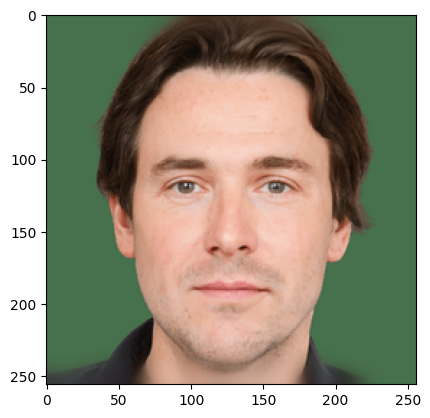

In [ ]:
#@markdown <h3> 🌄 pre-process the uploaded image 👨 👩 </h3>

uploaded_imgs_path = 'uploaded_imgs'
aligned_uploaded_imgs_path = 'aligned_uploaded_imgs'
if not osp.exists(aligned_uploaded_imgs_path) : os.makedirs(aligned_uploaded_imgs_path)

# !python align.py -i '{uploaded_imgs_path}' -o '{aligned_uploaded_imgs}'
# os.system(f'python align.py -i {uploaded_imgs_path}/ -o {aligned_uploaded_imgs_path}/')


!python align.py -i 'uploaded_imgs' -o 'aligned_uploaded_imgs'

imgdataset_path = aligned_uploaded_imgs_path  # path to your own image dataset
data = ImageDataset(imgdataset_path, image_size=model_config.img_size, exts=['jpg','jpeg', 'JPG', 'png'], do_augment=False)
plt.imshow(convert2rgb(data[0]['img']))

In [ ]:
print(data[0])

{'img': tensor([[[-0.4431, -0.4431, -0.4431,  ..., -0.4431, -0.4431, -0.4431],
         [-0.4431, -0.4431, -0.4431,  ..., -0.4431, -0.4431, -0.4431],
         [-0.4431, -0.4431, -0.4431,  ..., -0.4431, -0.4431, -0.4431],
         ...,
         [-0.5451, -0.5451, -0.5529,  ..., -0.4431, -0.4431, -0.4431],
         [-0.5451, -0.5451, -0.5451,  ..., -0.4431, -0.4431, -0.4431],
         [-0.5451, -0.5451, -0.5451,  ..., -0.4431, -0.4431, -0.4431]],

        [[-0.1216, -0.1216, -0.1216,  ..., -0.1216, -0.1216, -0.1216],
         [-0.1216, -0.1216, -0.1216,  ..., -0.1216, -0.1216, -0.1216],
         [-0.1216, -0.1216, -0.1216,  ..., -0.1216, -0.1216, -0.1216],
         ...,
         [-0.4980, -0.5059, -0.5137,  ..., -0.1216, -0.1216, -0.1216],
         [-0.5137, -0.5137, -0.5137,  ..., -0.1216, -0.1216, -0.1216],
         [-0.5059, -0.5137, -0.5137,  ..., -0.1216, -0.1216, -0.1216]],

        [[-0.4039, -0.4039, -0.4039,  ..., -0.4039, -0.4039, -0.4039],
         [-0.4039, -0.4039, -0.4039, 

In [ ]:
#@markdown <h3>  👶  🔁  👨 🔁  👴  Encode and Manipulate the uploaded image </h3>
#@markdown <h5> manipulation amplitude: The Strongness of Manipulation <h5/>.
# too strong would be resulted in artifact as it could dominate the original image information </small>
target_class = 'Mustache' #@param ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
manipulation_amplitude = 0.5 #@param {{type:"slider", min:-0.5, max:0.5, step:0.05}

# reverse the amplitude for some classes that are trained with opposite labels
cls_manipulation_amplitude = manipulation_amplitude
interpreted_target_class = target_class
if target_class not in CelebAttrDataset.id_to_cls and f'No_{target_class}' in CelebAttrDataset.id_to_cls:
  cls_manipulation_amplitude = -manipulation_amplitude
  interpreted_target_class = f'No_{target_class}'



batch = data[0]['img'][None]

semantic_latent = model.encode(batch.to(device))
stochastic_latent = model.encode_stochastic(batch.to(device), semantic_latent, T=T_inv)




cls_id = CelebAttrDataset.cls_to_id[interpreted_target_class]
class_direction = classifier.classifier.weight[cls_id]
normalized_class_direction = F.normalize(class_direction[None, :], dim=1)

normalized_semantic_latent = classifier.normalize(semantic_latent)
normalized_manipulation_amp = cls_manipulation_amplitude * math.sqrt(512)
normalized_manipulated_semantic_latent =  normalized_semantic_latent + normalized_manipulation_amp*normalized_class_direction

manipulated_semantic_latent = classifier.denormalize(normalized_manipulated_semantic_latent)

<ipython-input-26-b2c617c677e6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  convert_img = torch.tensor(img)


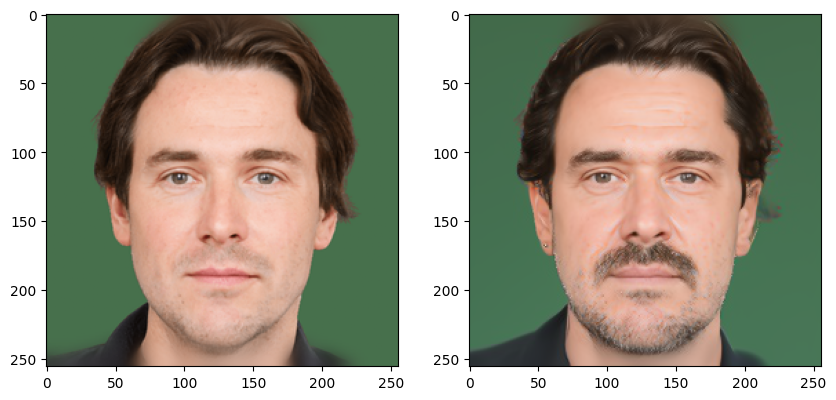

In [ ]:
#@markdown <h3> 😎 Render Manipulated image </h3>



manipulated_img = model.render(stochastic_latent, manipulated_semantic_latent, T=T_step)[0]
original_img = data[0]['img']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(convert2rgb(original_img))
ax[1].imshow(convert2rgb(manipulated_img,adjust_scale=False))
# plt.savefig('imgs_manipulated/compare.png')

In [ ]:

np.shape (manipulated_img)

torch.Size([3, 256, 256])

<h4> If you find our paper or code useful in your research, please consider citing: </h4>


<pre><code> @inproceedings{preechakul2021diffusion,
      title={Diffusion Autoencoders: Toward a Meaningful and Decodable Representation},
      author={Preechakul, Konpat and Chatthee, Nattanat and Wizadwongsa, Suttisak and Suwajanakorn, Supasorn},
      booktitle={IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
      year={2022},
}  <code>

In [ ]:
# Note:

# github is not published yet
# # [![GitHub stars](https://img.shields.io/github/stars//phizaz/diffae.svg?style=social&label=Star&maxAge=2592000)](https://github.com/phizaz/diffae)

# limit some class